In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# torch
import torch
from torch.utils.data import random_split
import pytorch_lightning 
from pytorch_lightning.loggers import CSVLogger

# vision
from torchvision.transforms import v2 as T
from torchvision.utils import save_image

# utils
from copy import copy
from tqdm import tqdm

# custom utils
from datasets.dataset import *
from helper_utils import my_utils, display
from models.smp_model import CatSegModel
from models.model_utils import build_trainer

Load Configuration:

In [14]:
config_name = "Unetpp_resnext50_32x4d_load.json"
paths, config = my_utils.load_configs(config_name)

{
  "NAME": "Unetpp_resnext50_32x4d_pretrained_DiceLoss",
  "MODE": "load"
}


### Data prep
Define transforms for the data:

In [15]:
# Example transformations
# @TODO: what is the corect image size
data_transforms = {}
data_transforms['train'] = T.Compose([
    T.RandomResizedCrop(size=640, scale=(0.5, 1)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToImage(),
    #T.ToDtype(torch.float32, scale=True)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_transforms['valid'] = T.Compose([
    T.Resize(670),
    T.CenterCrop(640),
    T.ToImage(),
    #T.ToDtype(torch.float32, scale=True)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_transforms['test'] = data_transforms['valid']

Build dataset:

In [16]:
# get files
full_dataset = SegmentationDataset(paths['train_data_root'])

# specify sizes
train_ratio = 0.7 # from total count
valid_ratio = 0.15 # from total count

# build datasets
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
valid_size = int(valid_ratio * total_size)
test_size = total_size - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])
train_dataset.dataset = copy(full_dataset) # disgusting solution for pytorch

# apply transforms
train_dataset.dataset.transform = data_transforms['train']
valid_dataset.dataset.transform = data_transforms['valid']
test_dataset.dataset.transform = data_transforms['test']

Plot a few images for example:

In [17]:
'''
for _ in range(3):
    index = np.random.randint(0, len(test_dataset) - 1)
    display_sample(train_dataset, index)
    '''

'\nfor _ in range(3):\n    index = np.random.randint(0, len(test_dataset) - 1)\n    display_sample(train_dataset, index)\n    '

In [18]:
# Generate files split
train_dl, valid_dl, test_dl =  build_dataloaders(train_dataset, valid_dataset, test_dataset, batch_size=2)

### Build model
Config load:

In [19]:
# setup
torch.set_float32_matmul_precision('high')
# build model
if config['MODE'] == 'train':
    model = CatSegModel(config)
    
elif config['MODE'] == 'load':
    # load model from checkpoint
    model = CatSegModel.load_from_checkpoint(
        checkpoint_path=os.path.join(paths['log_path'], config['NAME']+'_best-checkpoint.ckpt'),
        hparams_file=os.path.join(paths['log_path'], 'hparams.yaml')
    )

#### Build the PL trainer:

In [33]:
trainer, train_logger = build_trainer(config, paths)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


#### Train and plot convergance:

In [46]:
plot_metrics = ['dataset_iou', 'dataset_loss']

if config['MODE'] == 'train':
    # train using the included logger
    trainer.fit(model, 
        train_dataloaders=train_dl, 
        val_dataloaders=valid_dl)
    
    if plot_metrics != None:
        pth = os.path.join(train_logger.log_dir, 'metrics.csv')
        display.plot_losses(pth, plot_metrics)

### Test and Evaluate

In [45]:
test_csv_logger = CSVLogger(paths['log_path'], 'test')
trainer.logger = test_csv_logger

with torch.no_grad():
    model.eval()
    logger = test_csv_logger,
    tt=trainer.test(model= model, dataloaders = test_dl)

Missing logger folder: H:\Cataract Dataset\FSR Dataset\logs\Unetpp_resnext50_32x4d_pretrained_DiceLoss\test
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_dataset_iou        0.9710192680358887
    test_dataset_loss      0.015072979964315891
   test_per_image_iou       0.9714972376823425
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Test preformance:

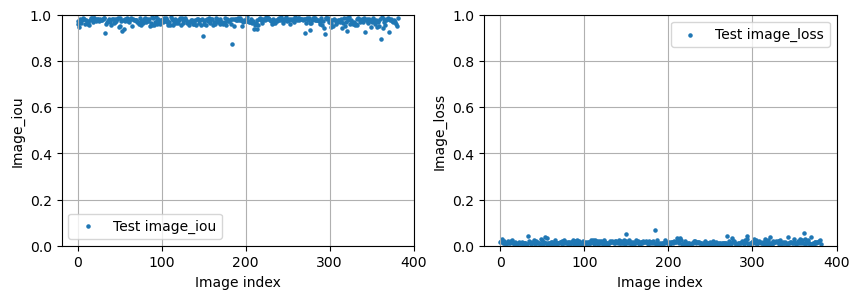

In [60]:
pth = os.path.join(paths['log_path'], 'test', 'metrics.csv')
display.plot_losses(pth, ['image_iou', 'image_loss'], test = True)

### Inference on additional dataset
This is for qualiative evaluation purposes. Data from different sources.

First we need to load the inference dataset:

In [136]:
# build dataset
infer_dataset = SegmentationInferenceDataset(paths['inference_data_root'], transform=data_transforms['test'], is_stereo=True)

Generate the masks:

In [83]:
import matplotlib.pyplot as plt

00001499_000002998_63915.png


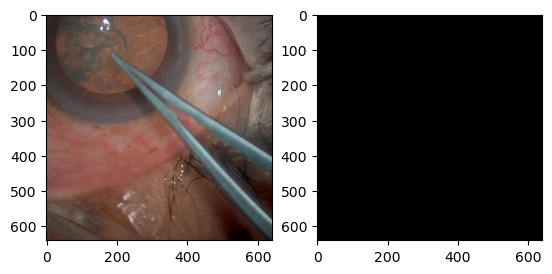

00001499_000002998_63915.png
00002499_000004998_99492.png
00002499_000004998_99492.png
00003499_000006998_80529.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00003499_000006998_80529.png
00004499_000008998_72785.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00004499_000008998_72785.png
00005499_000010998_55744.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00005499_000010998_55744.png
00006499_000012997_62764.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00006499_000012997_62764.png
00007499_000014997_04492.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00007499_000014997_04492.png
00008499_000016998_77258.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00008499_000016998_77258.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00009499_000018998_34524.png
00009499_000018998_34524.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00010499_000020998_27808.png
00010499_000020998_27808.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00011499_000022998_85143.png
00011499_000022998_85143.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00012499_000024998_36168.png
00012499_000024998_36168.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00013499_000026998_89517.png
00013499_000026998_89517.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00014499_000028998_80054.png
00014499_000028998_80054.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00015499_000030998_08409.png
00015499_000030998_08409.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00016499_000032998_20377.png
00016499_000032998_20377.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00017499_000034998_56221.png
00017499_000034998_56221.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00018499_000036998_93436.png
00018499_000036998_93436.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00019499_000038998_38335.png
00019499_000038998_38335.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00020499_000040998_82920.png
00020499_000040998_82920.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00021499_000042998_51340.png
00021499_000042998_51340.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00022499_000044998_98127.png
00022499_000044998_98127.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00023499_000046998_06497.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00023499_000046998_06497.png
00024499_000048998_51376.png
00024499_000048998_51376.png
00025499_000050998_91195.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00025499_000050998_91195.png
00026499_000052998_18163.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00026499_000052998_18163.png
00027499_000054998_58316.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00027499_000054998_58316.png
00028499_000056998_61608.png
00028499_000056998_61608.png
00029499_000058998_64072.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00029499_000058998_64072.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00030499_000060998_75938.png
00030499_000060998_75938.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00031499_000062998_30487.png
00031499_000062998_30487.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00032499_000064998_25407.png
00032499_000064998_25407.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00033499_000066998_86305.png
00033499_000066998_86305.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00034499_000068998_29172.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00034499_000068998_29172.png
00035499_000070998_61470.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00035499_000070998_61470.png
00036499_000072998_64963.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00036499_000072998_64963.png
00037499_000074998_14324.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00037499_000074998_14324.png
00038499_000076998_87634.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00038499_000076998_87634.png
00039499_000078998_72594.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00039499_000078998_72594.png
00040499_000080998_08066.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00040499_000080998_08066.png
00041499_000082998_73773.png
00041499_000082998_73773.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00042499_000084998_91738.png
00042499_000084998_91738.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00043499_000086998_67087.png
00043499_000086998_67087.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00044499_000088998_68322.png
00044499_000088998_68322.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00045499_000090998_92702.png
00045499_000090998_92702.png
00046499_000092998_70779.png
00046499_000092998_70779.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00047499_000094998_11902.png
00047499_000094998_11902.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00048499_000096998_02264.png
00048499_000096998_02264.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00049499_000098998_55365.png
00049499_000098998_55365.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00050499_000100998_98547.png
00050499_000100998_98547.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00051499_000102998_68730.png
00051499_000102998_68730.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00052499_000104998_66039.png
00052499_000104998_66039.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00053499_000106998_92644.png
00053499_000106998_92644.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00054499_000108998_92473.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00054499_000108998_92473.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00055499_000110998_17143.png
00055499_000110998_17143.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00056499_000112998_21512.png
00056499_000112998_21512.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00001499_000002998_39268.png
00001499_000002998_39268.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00002499_000004998_74299.png
00002499_000004998_74299.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00003499_000006998_73556.png
00003499_000006998_73556.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00004499_000008998_88497.png
00004499_000008998_88497.png
00005499_000010998_40995.png
00005499_000010998_40995.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00006499_000012997_11803.png
00006499_000012997_11803.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00007499_000014997_96954.png
00007499_000014997_96954.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00008499_000016998_54383.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00008499_000016998_54383.png
00009499_000018998_51649.png
00009499_000018998_51649.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00010499_000020998_92245.png
00010499_000020998_92245.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00011499_000022998_20774.png
00011499_000022998_20774.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00012499_000024998_40087.png
00012499_000024998_40087.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00013499_000026998_15235.png
00013499_000026998_15235.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00014499_000028998_00178.png
00014499_000028998_00178.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00015499_000030998_79192.png
00015499_000030998_79192.png
00016499_000032998_87104.png
00016499_000032998_87104.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00017499_000034998_04415.png
00017499_000034998_04415.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00018499_000036998_69280.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00018499_000036998_69280.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00019499_000038998_70409.png
00019499_000038998_70409.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00020499_000040998_35320.png
00020499_000040998_35320.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00021499_000042998_28174.png
00021499_000042998_28174.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00022499_000044998_25742.png
00022499_000044998_25742.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00023499_000046998_27372.png
00023499_000046998_27372.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00024499_000048998_56382.png
00024499_000048998_56382.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00025499_000050998_94803.png
00025499_000050998_94803.png
00026499_000052998_65123.png
00026499_000052998_65123.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00027499_000054998_72394.png
00027499_000054998_72394.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00028499_000056998_13417.png
00028499_000056998_13417.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00029499_000058998_79083.png
00029499_000058998_79083.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00030499_000060998_91564.png
00030499_000060998_91564.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00031499_000062998_67921.png
00031499_000062998_67921.png
00032499_000064998_20647.png
00032499_000064998_20647.png
00033499_000066998_04068.png
00033499_000066998_04068.png
00000599_000000999_90454.png
00000599_000000999_90454.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00001798_000002999_90024.png
00001798_000002999_90024.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00002997_000004999_12529.png
00002997_000004999_12529.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00004195_000006998_96336.png
00004195_000006998_96336.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00005394_000008998_61590.png
00005394_000008998_61590.png
00006593_000010999_19353.png
00006593_000010999_19353.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00007792_000012999_29412.png
00007792_000012999_29412.png
00008991_000014999_36114.png
00008991_000014999_36114.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00010189_000016998_08709.png
00010189_000016998_08709.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00011388_000018998_13336.png
00011388_000018998_13336.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00012587_000020999_75423.png
00012587_000020999_75423.png
00013786_000022999_25323.png
00013786_000022999_25323.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00014985_000024999_47036.png
00014985_000024999_47036.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00016183_000026998_05625.png
00016183_000026998_05625.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00017382_000028998_38027.png
00017382_000028998_38027.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00018581_000030999_36777.png
00018581_000030999_36777.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00019780_000032999_83566.png
00019780_000032999_83566.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00020979_000034999_99062.png
00020979_000034999_99062.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00022177_000036998_28866.png
00022177_000036998_28866.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00023376_000038998_81982.png
00023376_000038998_81982.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00024575_000040999_10053.png
00024575_000040999_10053.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00025774_000042999_40192.png
00025774_000042999_40192.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00026973_000044999_49414.png
00026973_000044999_49414.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00028171_000046998_17942.png
00028171_000046998_17942.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00029370_000048998_78734.png
00029370_000048998_78734.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00030569_000050999_09308.png
00030569_000050999_09308.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00031768_000052999_60231.png
00031768_000052999_60231.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00032967_000054999_14628.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00032967_000054999_14628.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00034165_000056998_14646.png
00034165_000056998_14646.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00035364_000058998_79143.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00035364_000058998_79143.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00036563_000060999_30143.png
00036563_000060999_30143.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


00037762_000062999_50377.png


KeyboardInterrupt: 

In [149]:
# save
os.makedirs(paths['inference_save_path'], exist_ok=True)

# Iterate over the predictions and save each image
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

fig, ax = plt.subplots(1, 2)

with torch.no_grad():
    # loop on images
    for idx, image in enumerate(infer_dataset):
        # cuda
        image = image.to(device)
        # setup
        image_name = infer_dataset.__get_img_name__(idx)
        save_path = os.path.join(paths['inference_save_path'], f'{image_name}_mask.png')
        # inference
        mask = model.infer(image).cpu()
        mask = mask.squeeze()
        # save
        save_image(mask, save_path)
        # show
        print(image_name)
        ax[0].imshow(image.cpu().permute(1, 2, 0))
        ax[1].imshow(mask, cmap='gray') 
        plt.show()
        if device.type == 'cuda':
            torch.cuda.empty_cache()
